## Import Libraries

In [ ]:
import numpy as np
from pathlib import Path
import pyjson5
import hdf5plugin
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from utils import init_model, validate_configs
import h5py

## Load Configs

In [ ]:
configs = pyjson5.load(open('/mnt/FLOGA/FLOGA-github/configs/config.json', 'r'))
configs['method'] = 'snunet'
model_configs = pyjson5.load(open(Path('/mnt/FLOGA/FLOGA-github/configs') / 'method' / f'{configs["method"]}.json', 'r'))

In [3]:
validate_configs(configs)
configs['mode'] = 'eval'

In [ ]:
resume_from_checkpoint = Path('/mnt/FLOGA/data/results/snunet/20240702072155/checkpoints/0/best_segmentation.pt')
run_path = Path(*resume_from_checkpoint.parts[:-3])
init_epoch = 0

In [ ]:
results_path = Path('/mnt/FLOGA/data/results/predictions/')

In [7]:
gsd = {"sen2": "60", "mod": "500"}

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])

0,1


In [8]:
data_source = configs['datasets']['data_source']
for band in configs['datasets']['selected_bands'][data_source].keys():
    configs['datasets']['selected_bands'][data_source][band] = configs['datasets'][f'{data_source}_bands'][gsd[data_source]][band]

In [9]:
inp_channels = len(configs['datasets']['selected_bands'][data_source])
inp_channels

9

In [19]:
device = 'cuda:0'

## Load Model

In [21]:
checkpoint = torch.load(resume_from_checkpoint, map_location=device)

In [22]:
model = init_model(configs, model_configs, checkpoint, inp_channels, device, run_path=run_path)
model = model[0]

In [23]:
from torch.nn.parallel import DataParallel
model = DataParallel(model, device_ids=[0,1])

In [24]:
model.eval()

DataParallel(
  (module): SNUNet_ECAM(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv0_0): conv_block_nested(
      (activation): ReLU(inplace=True)
      (conv1): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv1_0): conv_block_nested(
      (activation): ReLU(inplace=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Up1_0): up(
    

## Define Color Map

In [13]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', [(0, 0, 0, 10), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), (0.8647058823529412, 0.30980392156862746, 0.45882352941176474, 1.0)], 3)
title_font = {'size': '22'}
nplots = 4

In [14]:
bands = configs['datasets']['selected_bands'][data_source]
selected_bands_idx = {band: order_id for order_id, (band, _) in enumerate(bands.items())}

In [15]:
plot_bands = []
if set(['B08', 'B04', 'B03']) <= set(configs['datasets']['selected_bands']['sen2'].keys()):
    # NIR, Red, Green
    plot_bands = [selected_bands_idx[band] for band in ['B08', 'B04', 'B03']]
else:
    # NIR, Red, Green
    plot_bands = [selected_bands_idx[band] for band in ['B8A', 'B04', 'B03']]

In [16]:
plot_bands

[8, 2, 1]

## Load Image

In [ ]:
before_img = np.load('/mnt/FLOGA/data/dataset/2021/sample00000011_64_2021.sen2_60_pre.npy')
after_img = np.load('/mnt/FLOGA/data/dataset/2021/sample00000011_64_2021.sen2_60_post.npy')

In [29]:
before_img = before_img[list(bands.values()), :, :]
after_img = after_img[list(bands.values()), :, :]

In [30]:
before_img = np.expand_dims(before_img, axis=0)
after_img = np.expand_dims(after_img, axis=0)

print(f"Before Image shape: {before_img.shape}\nAfter Image shape: {after_img.shape}")

Before Image shape: (1, 9, 256, 256)
After Image shape: (1, 9, 256, 256)


In [31]:
before_img = before_img.astype('float32', copy=False)
after_img = after_img.astype('float32', copy=False)

In [32]:
before_img = torch.from_numpy(before_img)
after_img = torch.from_numpy(after_img)

In [33]:
# label = hdf['2018']['14']['label'][:]
# label = label.astype('float32')
# label = torch.from_numpy(label)

## Run Inference

In [34]:
before_img = before_img.to(device, copy=False)
after_img = after_img.to(device, copy=False)
with torch.no_grad():
    # label = label.to(device).long()
    output = model(before_img, after_img)

# predictions = output.argmax(1).to(dtype=torch.int8)

before_img = before_img.squeeze()
after_img = after_img.squeeze()
    # label = label.squeeze()

In [35]:
torch.cuda.empty_cache()

In [24]:
before_img.numpy(force=True)

array([[[ 125.,  125.,  118., ...,  407.,  369.,  495.],
        [ 132.,  126.,  126., ...,  313.,  340.,  397.],
        [ 136.,  129.,  129., ...,  442.,  270.,  511.],
        ...,
        [ 522.,  522.,  409., ...,  491.,  435.,  505.],
        [ 306.,  405.,  405., ...,  622.,  538.,  570.],
        [ 482.,  656.,  656., ...,  503.,  473.,  551.]],

       [[ 261.,  261.,  254., ...,  629.,  598.,  747.],
        [ 280.,  262.,  262., ...,  532.,  590.,  643.],
        [ 290.,  268.,  268., ...,  714.,  540.,  785.],
        ...,
        [ 806.,  806.,  686., ...,  773.,  677.,  747.],
        [ 559.,  695.,  695., ...,  908.,  772.,  822.],
        [ 768.,  990.,  990., ...,  761.,  709.,  797.]],

       [[ 192.,  192.,  177., ...,  752.,  701.,  938.],
        [ 197.,  184.,  184., ...,  580.,  642.,  716.],
        [ 208.,  193.,  193., ...,  864.,  449.,  906.],
        ...,
        [ 989.,  989.,  810., ..., 1012.,  840.,  991.],
        [ 654.,  870.,  870., ..., 1286., 103

In [52]:
# output = output.squeeze()
x = output.argmax(1)
x.shape

torch.Size([1, 256, 256])

In [53]:
x

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [0, 0, 1,  ..., 1, 0, 1],
         ...,
         [0, 0, 0,  ..., 0, 1, 1],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 1,  ..., 1, 1, 1]]], device='cuda:3')

In [49]:
predictions.shape

torch.Size([1, 256, 256])

In [133]:
np.unique(predictions.detach().cpu().numpy(), return_counts=True)

(array([0, 1], dtype=int8), array([57371,  8165]))

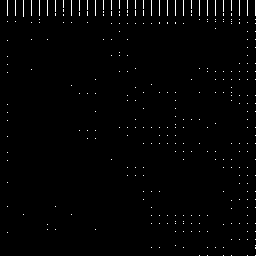

In [55]:
from PIL import Image
img = Image.fromarray(x.to(dtype=torch.int8).squeeze().detach().cpu().numpy(), mode='1')
img

array([63638,  1898]
array([57676,  7860]
array([58402,  7134]
array([58566,  6970]

In [132]:
np.unique(label.detach().cpu().numpy(), return_counts=True)

(array([0, 1, 2]), array([3394301,    1432,   15026]))

## Plot Output

In [34]:
plot_i = 0

In [27]:
before_img = before_img[plot_bands, :, :].detach().cpu().numpy()
before_img = np.clip(before_img, a_min=0, a_max=1)

In [28]:
after_img = after_img[plot_bands, :, :].detach().cpu().numpy()
after_img = np.clip(after_img, a_min=0, a_max=1)

In [29]:
predictions = predictions.squeeze().cpu().detach().numpy()

In [30]:
before_img = np.moveaxis(before_img, 0, -1)
after_img = np.moveaxis(after_img, 0, -1)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(80, 10), num=1, clear=True)
axes[plot_i].imshow(before_img)

axes[plot_i].set_title(f'S-2 Before ({23})', fontdict=title_font)
axes[plot_i].set_xticks([])
axes[plot_i].set_yticks([])
axes[plot_i].spines['top'].set_visible(False)
axes[plot_i].spines['right'].set_visible(False)
axes[plot_i].spines['bottom'].set_visible(False)
axes[plot_i].spines['left'].set_visible(False)
plot_i += 1

axes[plot_i].imshow(after_img)

axes[plot_i].set_title(f'S-2 After ({23})', fontdict=title_font)
axes[plot_i].set_xticks([])
axes[plot_i].set_yticks([])
axes[plot_i].spines['top'].set_visible(False)
axes[plot_i].spines['right'].set_visible(False)
axes[plot_i].spines['bottom'].set_visible(False)
axes[plot_i].spines['left'].set_visible(False)
plot_i += 1

# label = label.squeeze().cpu().detach().numpy()
# axes[plot_i].imshow(label, vmin=0, vmax=2, cmap=cmap)
# axes[plot_i].set_title(f'S-2 Label ({23})', fontdict=title_font)
# axes[plot_i].set_xticks([])
# axes[plot_i].set_yticks([])
# axes[plot_i].spines['top'].set_visible(False)
# axes[plot_i].spines['right'].set_visible(False)
# axes[plot_i].spines['bottom'].set_visible(False)
# axes[plot_i].spines['left'].set_visible(False)
# plot_i += 1

axes[plot_i].imshow(predictions, vmin=0, vmax=2, cmap=cmap)
axes[plot_i].set_title(f'S-2 Prediction ({23})', fontdict=title_font)
axes[plot_i].set_xticks([])
axes[plot_i].set_yticks([])
axes[plot_i].spines['top'].set_visible(False)
axes[plot_i].spines['right'].set_visible(False)
axes[plot_i].spines['bottom'].set_visible(False)
axes[plot_i].spines['left'].set_visible(False)
plot_i += 1

In [32]:
# Define custom colormap for the labels
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', [(0, 0, 0, 10), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), (0.8647058823529412, 0.30980392156862746, 0.45882352941176474, 1.0)], 3)
cmap_sea = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap clouds', [(0, 0, 0, 1.0), (1.0, 1.0, 1.0, 1.0)], 2)
cmap_clc = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap clc', 
    [
        (0, 0, 0, 1.0),  # NODATA
        (0.902, 0.0, 0.302, 1.0),  # Continuous urban fabric
        (1.0, 0.0, 0.0, 1.0),  # Discontinuous urban fabric
        (0.8, 0.302, 0.949, 1.0),  # Industrial or commercial units
        (0.8, 0.0, 0.0, 1.0),  # Road and rail networks and associated land
        (0.902, 0.8, 0.8, 1.0),  # Port areas
        (0.901, 0.8, 0.902, 1.0),  # Airports
        (0.651, 0.0, 0.8, 1.0),  # Mineral extraction sites
        (0.651, 0.302, 1.0, 1.0),  # Dump sites
        (1.0, 0.302, 1.0, 1.0),  # Construction sites
        (1.0, 0.651, 1.0, 1.0),  # Green urban areas
        (1.0, 0.902, 1.0, 1.0),  # Sport and leisure facilities
        (1.0, 1.0, 0.659, 1.0),  # Non-irrigated arable land
        (1.0, 1.0, 0.0, 1.0),  # Permanently irrigated land
        (0.902, 0.902, 0.0, 1.0),  # Rice fields
        (0.902, 0.502, 0.0, 1.0),  # Vineyards
        (0.949, 0.651, 0.302, 1.0),  # Fruit trees and berry plantations
        (0.902, 0.651, 0.0, 1.0),  # Olive groves
        (0.902, 0.902, 0.302, 1.0),  # Pastures
        (1.0, 0.902, 0.651, 1.0),  # Annual crops associated with permanent crops
        (1.0, 0.902, 0.302, 1.0),  # Complex cultivation patterns
        (0.902, 0.8, 0.302, 1.0),  # Land principally occupied by agriculture with significant areas of natural vegetation
        (0.949, 0.8, 0.651, 1.0),  # Agro-forestry areas
        (0.502, 1.0, 0.0, 1.0),  # Broad-leaved forest
        (0.0, 0.651, 0.0, 1.0),  # Coniferous forest
        (0.302, 1.0, 0.0, 1.0),  # Mixed forest
        (0.8, 0.949, 0.302, 1.0),  # Natural grasslands
        (0.651, 1.0, 0.502, 1.0),  # Moors and heathland
        (0.651, 0.902, 0.302, 1.0),  # Sclerophyllous vegetation
        (0.651, 0.949, 0.0, 1.0),  # Transitional woodland-shrub
        (0.902, 0.902, 0.902, 1.0),  # Beaches dunes sands
        (0.8, 0.8, 0.8, 1.0),  # Bare rocks
        (0.8, 1.0, 0.8, 1.0),  # Sparsely vegetated areas
        (0.0, 0.0, 0.0, 1.0),  # Burnt areas
        (0.651, 0.902, 0.8, 1.0),  # Glaciers and perpetual snow
        (0.651, 0.651, 1.0, 1.0),  # Inland marshes
        (0.302, 0.302, 1.0, 1.0),  # Peat bogs
        (0.8, 0.8, 1.0, 1.0),  # Salt marshes
        (0.902, 0.902, 1.0, 1.0),  # Salines
        (0.651, 0.651, 0.902, 1.0),  # Intertidal flats
        (0.0, 0.8, 0.949, 1.0),  # Water courses
        (0.0, 1.0, 0.651, 1.0),  # Coastal lagoons
        (0.651, 1.0, 0.902, 1.0),  # Estuaries
        (0.902, 0.949, 1.0, 1.0),  # Sea and ocean
    ],
    44
)

In [ ]:
floga_path = Path('/mnt/FLOGA/dataset/FLOGA_dataset_2018_sen2_60_mod_500.h5')
hdf = h5py.File(floga_path, 'r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010804971..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04139073..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.0].


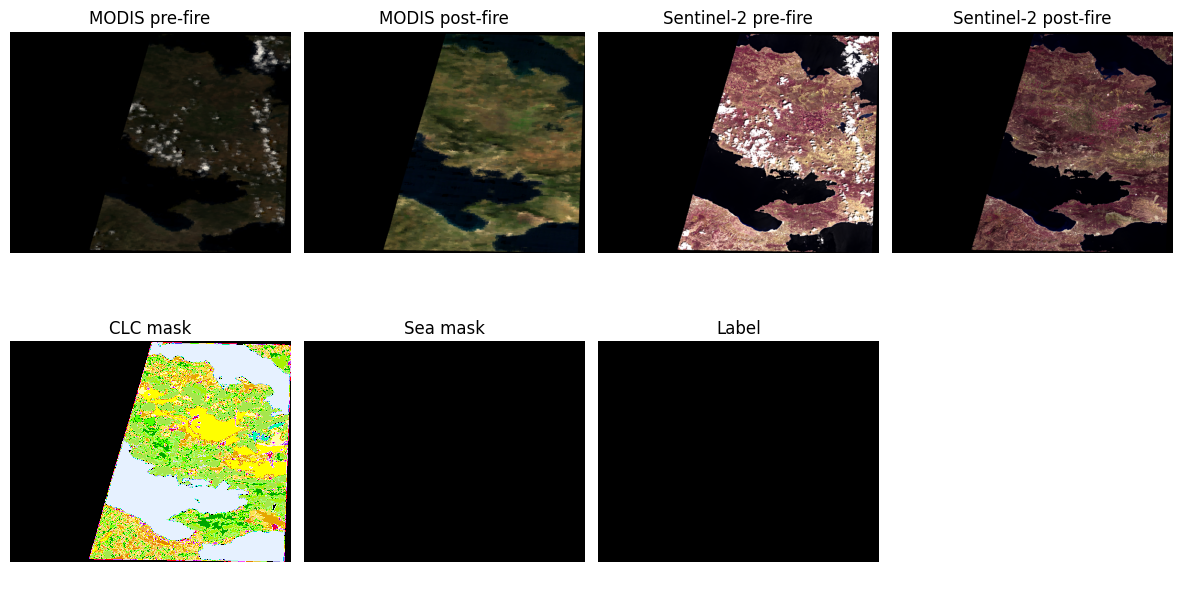

In [133]:
def scale_image(img):
    img = img.astype(np.float32)
    return img / img.max()

event_id = '14'
bands = 'nrg'  # 'nrg' for NIR-R-G composites, 'rgb' for R-G-B composites

if bands == 'nrg':
    # Get band indices for R, G, B
    sen2_plot_bands = [3, 2, 1]
    mod_plot_bands = [0, 3, 2]
else:
    # Get band indices for NIR, R, G
    sen2_plot_bands = [10, 3, 2]
    mod_plot_bands = [1, 0, 3]

fig, ax = plt.subplots(2, 4, figsize=(15, 8))

# MODIS pre-fire image
img = hdf['2018'][event_id]['mod_500_pre'][:][mod_plot_bands, ...]
img = scale_image(img)
img = np.moveaxis(img, 0, -1)
ax[0, 0].imshow(img)
ax[0, 0].set_title('MODIS pre-fire')

# MODIS post-fire image
img = hdf['2018'][event_id]['mod_500_post'][:][mod_plot_bands, ...]
img = scale_image(img)
img = np.moveaxis(img, 0, -1)
ax[0, 1].imshow(img)
ax[0, 1].set_title('MODIS post-fire')

# Sentinel-2 pre-fire image
before_img = before_img[:, :, :].detach().cpu().numpy()
img = before_img[sen2_plot_bands, ...]
img = scale_image(img)
img = np.moveaxis(img, 0, -1)
ax[0, 2].imshow(img * 7)
ax[0, 2].set_title('Sentinel-2 pre-fire')

# Sentinel-2 post-fire image
after_img = after_img[:, :, :].detach().cpu().numpy()
img = after_img[sen2_plot_bands, ...]
img = scale_image(img)
img = np.moveaxis(img, 0, -1)
ax[0, 3].imshow(img * 7)
ax[0, 3].set_title('Sentinel-2 post-fire')

# CLC mask
img = hdf['2018'][event_id]['clc_100_mask'][:]
img[(img == 48) | (img == 128)] = 0  # NODATA
img = np.moveaxis(img, 0, -1)
ax[1, 0].imshow(img, vmin=0, vmax=43, cmap=cmap_clc)
ax[1, 0].set_title('CLC mask')

# Sea mask
img = hdf['2018'][event_id]['sea_mask'][:]
ax[1, 1].imshow(img.squeeze(), vmin=0, vmax=1, cmap=cmap_sea)
ax[1, 1].set_title('Sea mask')

# Label
ax[1, 2].imshow(predictions.squeeze()[:, :].detach().cpu().numpy(), vmin=0, vmax=2, cmap=cmap)
ax[1, 2].set_title('Label')

# Remove axes and ticks
for i in range(2):
    for j in range(4):
        # Remove all axis labels
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

        ax[i, j].spines['top'].set_visible(False)
        ax[i, j].spines['right'].set_visible(False)
        ax[i, j].spines['bottom'].set_visible(False)
        ax[i, j].spines['left'].set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0.01)

In [134]:
img = hdf['2018'][event_id]['sea_mask'][:]
img.shape

(1, 1639, 2081)

In [135]:
np.unique(img.squeeze())

array([  0,   1,   2,   3,   4, 253, 255], dtype=uint8)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:3', dtype=torch.int8)

In [148]:
final = predictions.squeeze()[:, :].detach().cpu().numpy()

In [149]:
np.unique(final)

array([0, 1], dtype=int8)

In [150]:
final = final.astype('int32')

In [143]:
final = final * 255

In [145]:
np.unique(final)

array([  0, 255], dtype=int32)

In [146]:
from PIL import Image

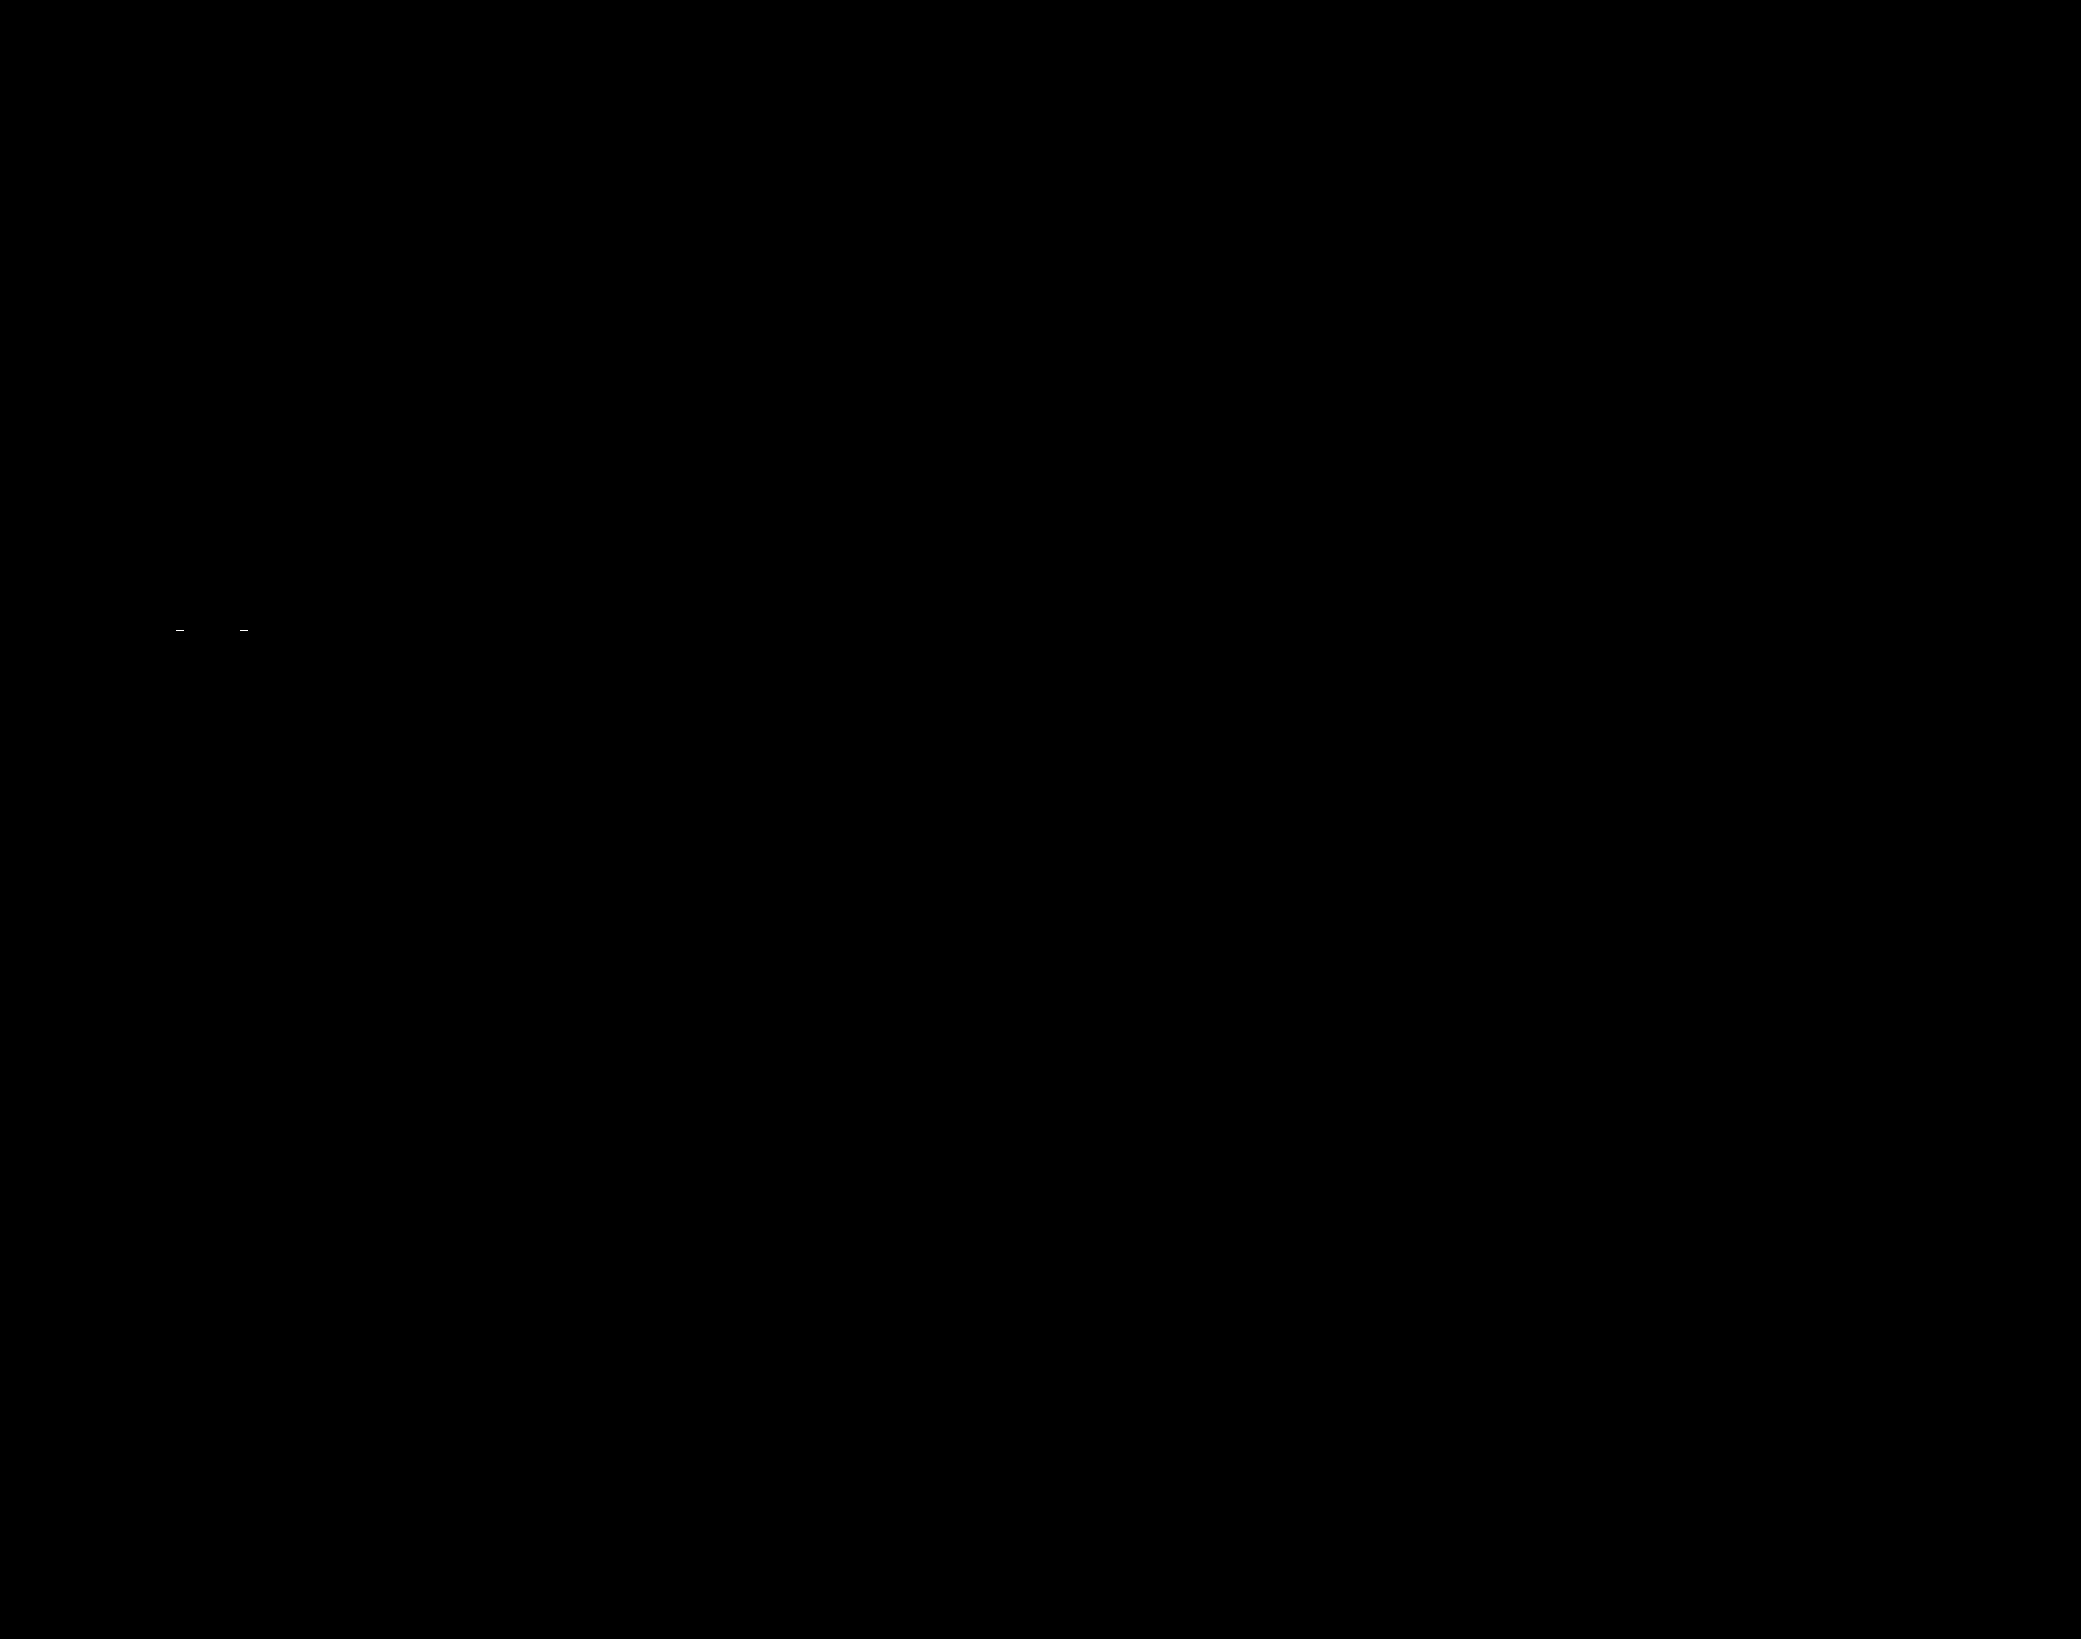

In [147]:
i = Image.fromarray(final, mode='1')
i

In [153]:
import PIL

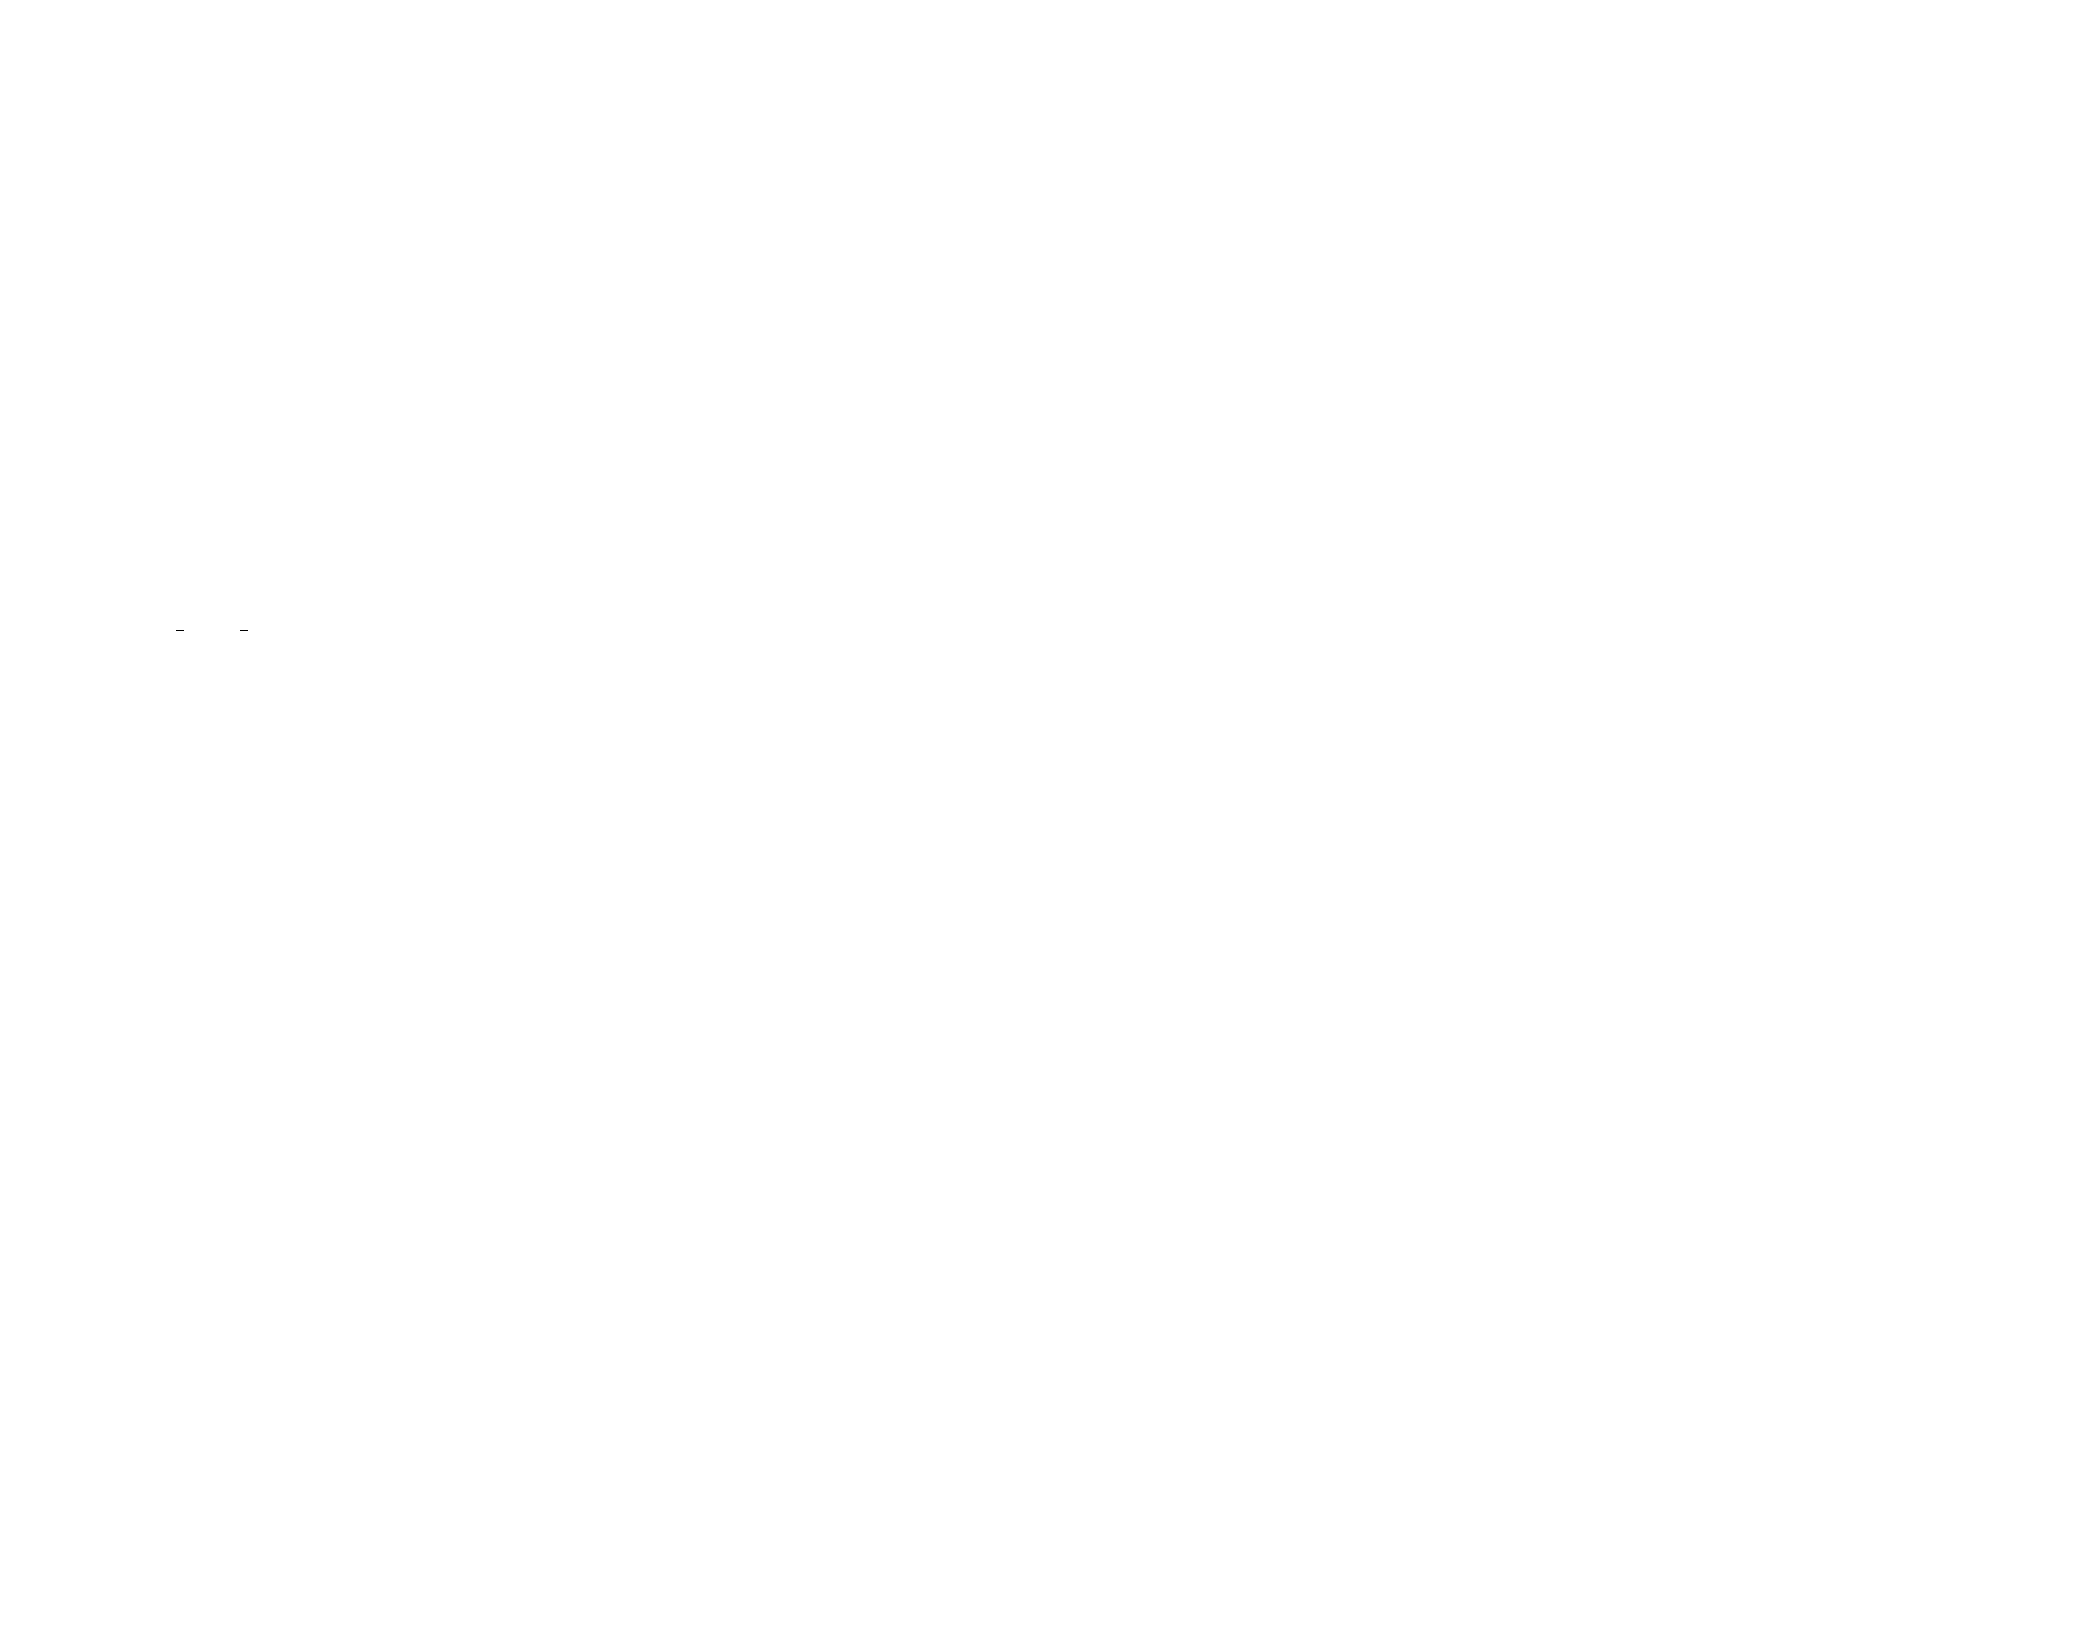

In [154]:
PIL.ImageOps.invert(i)

In [2]:
from gradio_demo import generate_mask

In [ ]:
examples = [['/mnt/FLOGA/data/dataset/2021/sample00000020_145_2021.sen2_60_pre.npy',
         '/mnt/FLOGA/data/dataset/2021/sample00000020_145_2021.sen2_60_post.npy',
         '/mnt/FLOGA/data/dataset/2021/sample00000020_145_2021.label.npy'
         ],
         ['/mnt/FLOGA/data/dataset/2021/sample00000004_75_2021.sen2_60_pre.npy',
          '/mnt/FLOGA/data/dataset/2021/sample00000004_75_2021.sen2_60_post.npy',
          '/mnt/FLOGA/data/dataset/2021/sample00000004_75_2021.label.npy'
          ],
          ['/mnt/FLOGA/data/dataset/2021/sample00000011_64_2021.sen2_60_pre.npy',
          '/mnt/FLOGA/data/dataset/2021/sample00000011_64_2021.sen2_60_post.npy',
          '/mnt/FLOGA/data/dataset/2021/sample00000011_64_2021.label.npy'
          ]]

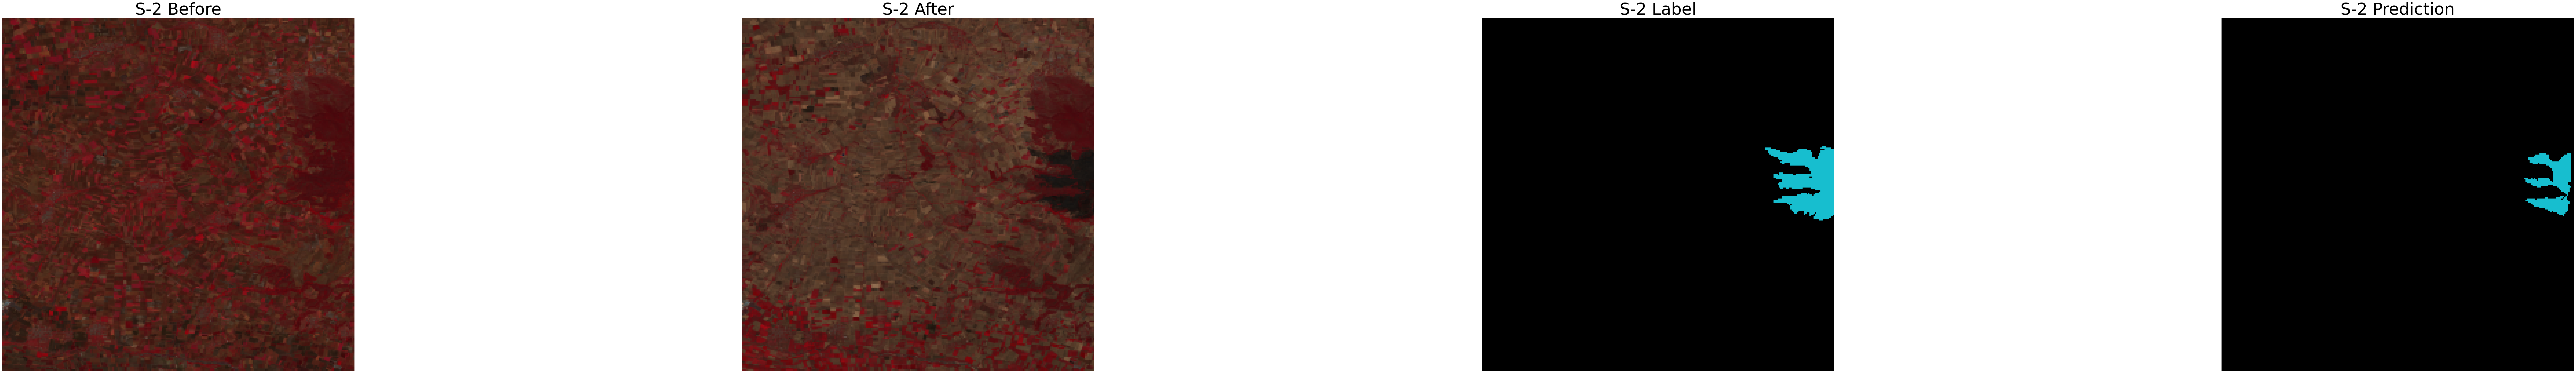

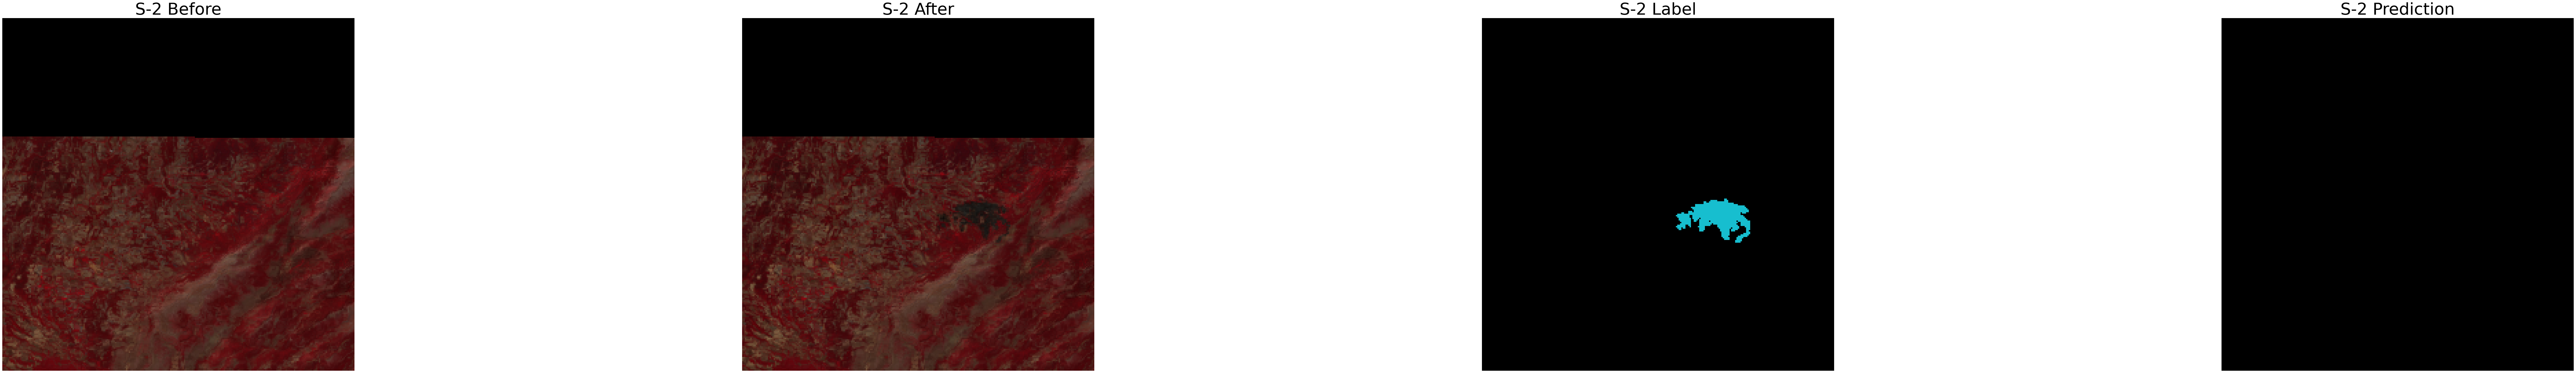

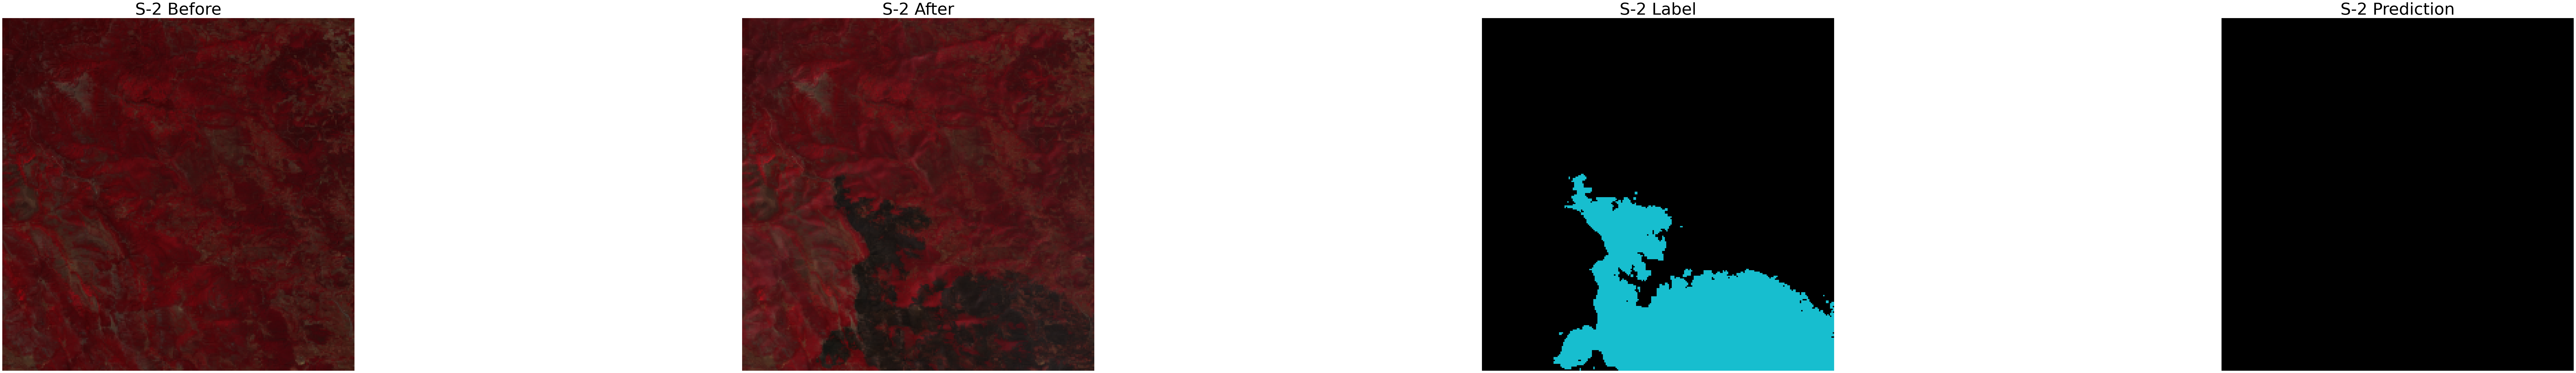

In [4]:
for i, e in enumerate(examples):
    image = generate_mask(open(e[0], 'rb'), open(e[1], 'rb'), open(e[2], 'rb'))
    image.save(f"{i}.png")